In [1]:
import pandas as pd
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px
from jupyter_dash import JupyterDash

In [2]:
spacex_df = pd.read_csv("spacex_launch_dash.csv")
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

In [5]:
JupyterDash.infer_jupyter_proxy_config()

In [4]:

# Create a dash application
# app = dash.Dash(__name__)

app = JupyterDash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                # dcc.Dropdown(id='site-dropdown',...)
                                dcc.Dropdown(id='site-dropdown',
                                    options=[
                                        {'label': 'All Sites', 'value': 'ALL'},
                                        {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                        {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                        {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'},
                                        {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}
                                    ],
                                    value='ALL',
                                    placeholder="Select a Launch Site here",
                                    searchable=True
                                    ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                    min=0, max=10000, step=1000,
                                    marks={
                                        0: '0',
                                        1000:  '1000',
                                        2500:  '2500',
                                        5000:  '5000',
                                        7500:  '7500',
                                        10000: '10000'},
                                    value=[min_payload, max_payload]),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    if entered_site == 'ALL':
        fig = px.pie(spacex_df, values='class', 
        names='Launch Site', 
        title='Total Success Launches By Site')
        return fig
    else:
        filtered_df = spacex_df[spacex_df["Launch Site"] == entered_site]['class'].value_counts()
        fig = px.pie(values=filtered_df.values, 
        names=filtered_df.index, 
        title=f'Total Success Launches For Site {entered_site}')
        return fig
# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output

@app.callback(
    Output(component_id='success-payload-scatter-chart', component_property='figure'),
    [Input(component_id='site-dropdown', component_property='value'), Input(component_id="payload-slider", component_property="value")]
)
def update_slider(entered_site, payload_range):
    range_filtered = spacex_df[
        (spacex_df['Payload Mass (kg)'] >= payload_range[0]) &
        (spacex_df['Payload Mass (kg)'] <= payload_range[1])
    ]
    
    if entered_site == 'ALL':
        fig = px.scatter(range_filtered, x='Payload Mass (kg)', y='class', color='Booster Version Category', title="Correlation Between Payload and Success for All Sites")
        fig.update_traces(marker_size=10)   # change marker size
        fig.update_yaxes(type='category')   # treat axis as categorical, removes other ticks 
        return fig
    else:
        range_site = range_filtered[range_filtered['Launch Site'] == entered_site]
        fig = px.scatter(range_site, x='Payload Mass (kg)', y='class', color='Booster Version Category', title=f"Correlation Between Payload and Success for Site {entered_site}")
        fig.update_traces(marker_size=10)
        fig.update_yaxes(type='category')
        return fig
    
# Run the app
if __name__ == '__main__':
    app.run_server(mode='inline')

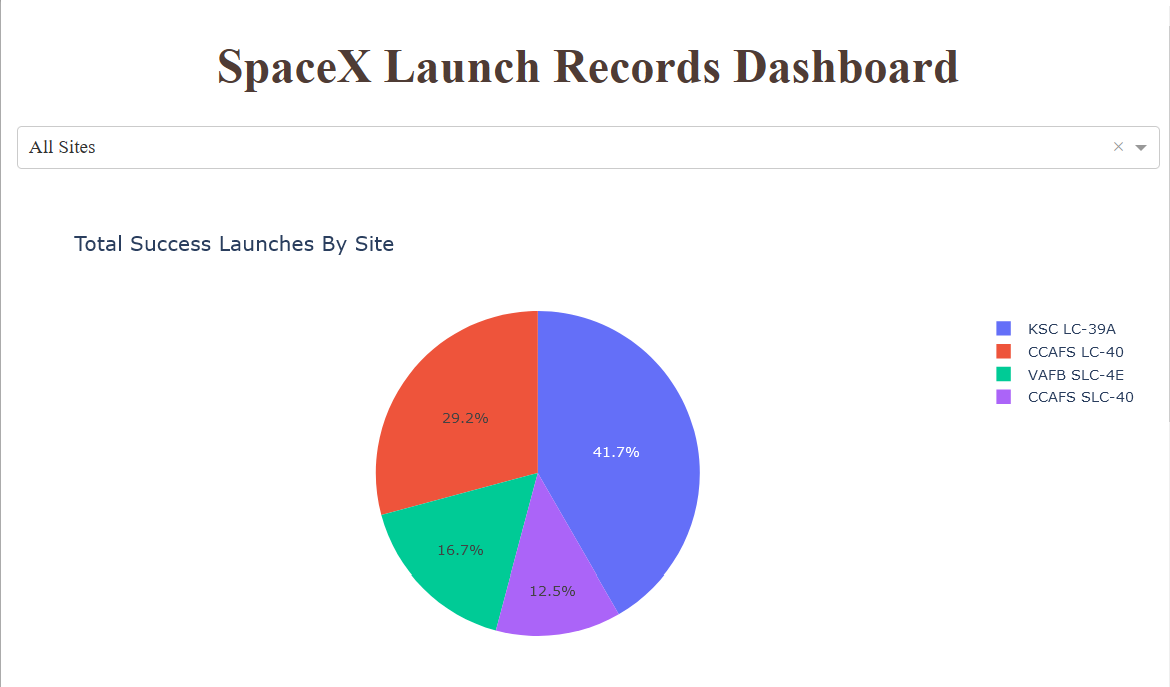
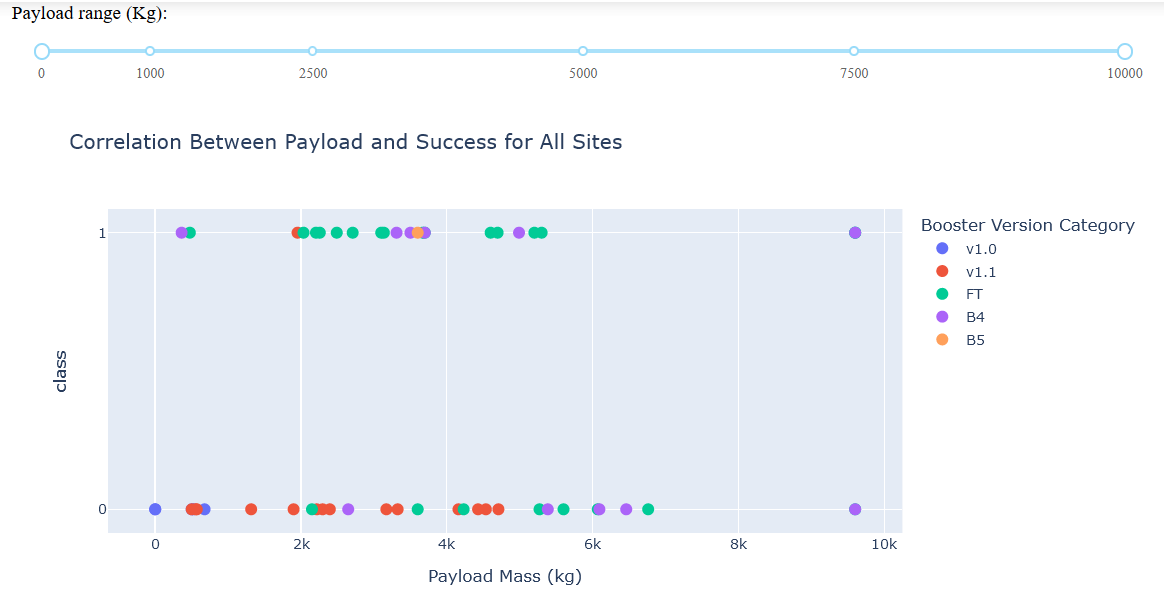